## Measuring $b^{\dagger}b$

In [1]:
import sys
sys.path.append('..')
from src.sympy_utilities import *#

import sympy as sp
import pickle


ho_ham = pickle.load(open("DATA/ho_hamiltonian.p", "rb"))


observable = bdag*b
print(observable)

fq = max_sympy_exponent(ho_ham)

xf = sp.Symbol('X^'+str(fq),commutative=False)
yf = sp.Symbol('Y^'+str(fq),commutative=False)
zf = sp.Symbol('Z^'+str(fq),commutative=False)
idf = sp.Symbol('I^'+str(fq),commutative=False)

nq = fq+1
b_ps = 0.5*xf+0.5*complex(0,1)*yf
bdag_ps = 0.5*xf-0.5*complex(0,1)*yf
commutation_lhs = xf*yf-yf*xf
commutation_rhs = 2*complex(0,1)*zf


bd*b


In [2]:
obs_ps = sp.simplify(observable.subs({b: b_ps, bdag: bdag_ps})).subs(commutation_lhs, commutation_rhs)
obs_ps = sp.expand(obs_ps)
obs_ps = sp.simplify(obs_ps.subs({xf*xf: idf, yf*yf: idf}))

obs_ps

0.5*I^3 + 0.25*I*X^3*Y^3 - 0.25*I*Y^3*X^3

So this tells us that 
\begin{equation}
    \langle b^{\dagger} b \rangle = \langle 0.5 I^3 \rangle + \langle 0.25iX^3Y^3 \rangle - \langle 0.25 i Y^3 X^3 \rangle.
\end{equation}
By substituting in the pauli matrices this is just 
\begin{equation}
    \langle b^{\dagger} b \rangle = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}
\end{equation}

which is not unitary?!?!  But I guess observables only need to be Hermitian which this is with eigenvalues 0 and 1.  And three quantum circuits measuring each of the three expectectation values will make three unitary circuits.  

In [3]:
from src.sympy_utilities import identity_qubit_padded_H

identity_qubit_padded_H(obs_ps)

0.5*I^0*I^1*I^2*I^3 + 0.25*I*I^0*I^1*I^2*X^3*Y^3 - 0.25*I*I^0*I^1*I^2*Y^3*X^3

In [4]:
from qiskit.aqua.operators import I,X,Y,Z 

str_to_op = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
        
tst = str(identity_qubit_padded_H(obs_ps))
print(tst)

0.5*I^0*I^1*I^2*I^3 + 0.25*I*I^0*I^1*I^2*X^3*Y^3 - 0.25*I*I^0*I^1*I^2*Y^3*X^3


In [5]:
import re

res = re.split('(\+|\-)',tst)
print(res)
term_lst = res[1].split('*')

coef = 1.
ops = [I for i in range(nq)]

for t in term_lst:
    if(len(t.split('^'))==1):
        if(t=='I'):
            coef*=1.0j
        else:
            coef*=float(t)
    else:
        op = t.split('^')
     #   print(op)
        ops[int(op[1])] = ops[int(op[1])] @ str_to_op[op[0]]
    #print(ops[3])

res = ops[0]
for i in range(1,len(ops)):
    res = res^ops[i]
res = coef*res

print(res)

['0.5*I^0*I^1*I^2*I^3 ', '+', ' 0.25*I*I^0*I^1*I^2*X^3*Y^3 ', '-', ' 0.25*I*I^0*I^1*I^2*Y^3*X^3']


ValueError: could not convert string to float: '+'

In [6]:
def observable_term_to_qiskit(expr, nq):
    print('expr={}'.format(expr))
    terms = expr.split('*')
    coef = 1.
    ops = [I for i in range(nq)]

    for t in terms:
        if(len(t.split('^'))==1):
            if(t=='I'):
                coef*=1.0j
            else:
                coef*=float(t)
        else:
            op = t.split('^')
     #   print(op)
            ops[int(op[1])] = ops[int(op[1])] @ str_to_op[op[0]]
    #print(ops[3])

    res = ops[0]
    for i in range(1,len(ops)):
        res = res^ops[i]
    
    res = coef*res
    return res

In [7]:
from qiskit.aqua.operators import StateFn

tstSplit=re.split('(\+|\-)',tst)
circuit = 0
sign=1
for t in tstSplit:
    if(t=='+'):
        continue
    elif(t=='-'):
        sign*=-1
        continue
    print(observable_term_to_qiskit(t,nq))
    circuit+=sign*observable_term_to_qiskit(t,nq)
print(circuit)
observableCircuit = StateFn(circuit).adjoint()
print(observableCircuit)

expr=0.5*I^0*I^1*I^2*I^3 
0.5 * IIII
expr=0.5*I^0*I^1*I^2*I^3 
expr= 0.25*I*I^0*I^1*I^2*X^3*Y^3 
(-0.25+0j) * IIIZ
expr= 0.25*I*I^0*I^1*I^2*X^3*Y^3 
expr= 0.25*I*I^0*I^1*I^2*Y^3*X^3
(0.25+0j) * IIIZ
expr= 0.25*I*I^0*I^1*I^2*Y^3*X^3
SummedOp([
  0.5 * IIII,
  (-0.25+0j) * IIIZ,
  (-0.25+0j) * IIIZ
])
OperatorMeasurement(SummedOp([
  0.5 * IIII,
  (-0.25-0j) * IIIZ,
  (-0.25-0j) * IIIZ
]))


In [8]:
import pickle

ho_ham = pickle.load(open("DATA/ho_hamiltonian.p", "rb"))
aho_ham = pickle.load(open("DATA/aho_hamiltonian.p", "rb"))

import sys
sys.path.append('..')
from src.qiskit_utilities import *

trotter_step = pauli_string_to_trotter_step(ho_ham,1)

print(trotter_step)

global phase: -4
      ┌───────┐   ┌───────┐  
q_0: ─┤ RZ(1) ├───┤ RZ(1) ├──
      ├───────┴┐  ├───────┴┐ 
q_1: ─┤ RZ(-2) ├──┤ RZ(-2) ├─
      ├────────┤  ├────────┤ 
q_2: ─┤ RZ(-1) ├──┤ RZ(-1) ├─
     ┌┴────────┴┐┌┴────────┴┐
q_3: ┤ RZ(-0.5) ├┤ RZ(-0.5) ├
     └──────────┘└──────────┘


In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit import (
    execute,
    Aer)
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ
from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()

/home/chrisculver/miniconda3/envs/QuantumComputing/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [10]:
#observableCircuit = StateFn(observable_term_to_qiskit('0.5*I^0*I^1*I^2*I^3',4)-observable_term_to_qiskit('0.5*I^0*I^1*I^2*Z^3',4)).adjoint()

fullCircuit = observableCircuit @ trotter_step @ Zero
print(fullCircuit)

ComposedOp([
  OperatorMeasurement(SummedOp([
    0.5 * IIII,
    (-0.25-0j) * IIIZ,
    (-0.25-0j) * IIIZ
  ])),
  CircuitStateFn(
  global phase: -4
        ┌───────┐   ┌───────┐  
  q_0: ─┤ RZ(1) ├───┤ RZ(1) ├──
        ├───────┴┐  ├───────┴┐ 
  q_1: ─┤ RZ(-2) ├──┤ RZ(-2) ├─
        ├────────┤  ├────────┤ 
  q_2: ─┤ RZ(-1) ├──┤ RZ(-1) ├─
       ┌┴────────┴┐┌┴────────┴┐
  q_3: ┤ RZ(-0.5) ├┤ RZ(-0.5) ├
       └──────────┘└──────────┘
  )
])


In [11]:
fullCircuit.eval()

0j

In [12]:
fullCircuit[1].to_circuit().draw()

global phase: -4
      ┌───────┐   ┌───────┐  
q_0: ─┤ RZ(1) ├───┤ RZ(1) ├──
      ├───────┴┐  ├───────┴┐ 
q_1: ─┤ RZ(-2) ├──┤ RZ(-2) ├─
      ├────────┤  ├────────┤ 
q_2: ─┤ RZ(-1) ├──┤ RZ(-1) ├─
     ┌┴────────┴┐┌┴────────┴┐
q_3: ┤ RZ(-0.5) ├┤ RZ(-0.5) ├
     └──────────┘└──────────┘

In [13]:
obs1=StateFn(observable_term_to_qiskit('0.5*I^0*I^1*I^2*I^3',4)).adjoint()
circuit=(obs1@trotter_step@Zero)
print(circuit)

expr=0.5*I^0*I^1*I^2*I^3
ComposedOp([
  OperatorMeasurement(0.5 * IIII),
  CircuitStateFn(
  global phase: -4
        ┌───────┐   ┌───────┐  
  q_0: ─┤ RZ(1) ├───┤ RZ(1) ├──
        ├───────┴┐  ├───────┴┐ 
  q_1: ─┤ RZ(-2) ├──┤ RZ(-2) ├─
        ├────────┤  ├────────┤ 
  q_2: ─┤ RZ(-1) ├──┤ RZ(-1) ├─
       ┌┴────────┴┐┌┴────────┴┐
  q_3: ┤ RZ(-0.5) ├┤ RZ(-0.5) ├
       └──────────┘└──────────┘
  )
])


In [14]:
circuit[1].to_circuit().draw()

global phase: -4
      ┌───────┐   ┌───────┐  
q_0: ─┤ RZ(1) ├───┤ RZ(1) ├──
      ├───────┴┐  ├───────┴┐ 
q_1: ─┤ RZ(-2) ├──┤ RZ(-2) ├─
      ├────────┤  ├────────┤ 
q_2: ─┤ RZ(-1) ├──┤ RZ(-1) ├─
     ┌┴────────┴┐┌┴────────┴┐
q_3: ┤ RZ(-0.5) ├┤ RZ(-0.5) ├
     └──────────┘└──────────┘

4


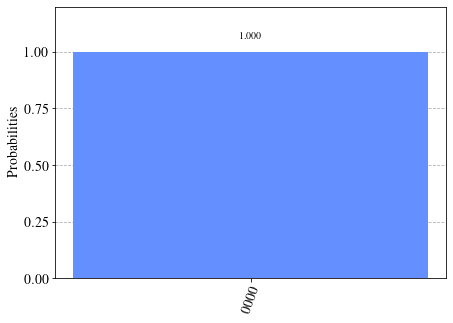

In [25]:
from qiskit import (execute, Aer)
from qiskit import ClassicalRegister
simulator = Aer.get_backend('qasm_simulator')
cr = ClassicalRegister(4,'nc')
print(nq)

qc = circuit[1].to_circuit()
qc.add_register(cr)
qc.measure([i for i in range(nq)],[i for i in range(nq)])
job = execute(qc, simulator, shots=1000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [15]:
from qiskit.aqua.operators import CircuitSampler
from qiskit import BasicAer
import numpy as np

In [16]:
sampler = CircuitSampler(backend=BasicAer.get_backend('qasm_simulator'))

sampled_circuit = sampler.convert(fullCircuit)

In [17]:
sampled_circuit_results = sampled_circuit.eval()

In [18]:
print('Sampled results:\n{}'.format(np.real(sampled_circuit_results)))

Sampled results:
0.0


In [19]:
print(sampled_circuit)

ComposedOp([
  OperatorMeasurement(SummedOp([
    0.5 * IIII,
    (-0.25-0j) * IIIZ,
    (-0.25-0j) * IIIZ
  ])),
  DictStateFn({'0000': 1.0})
])
